In [ ]:
import pandas as pd
import numpy as np

### Load Data

## Kaggle

In [ ]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mondhirch","key":"03a491ad2fe5eb1a1d2cdacf1282a741"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

 88% 17.0M/19.4M [00:00<00:00, 56.7MB/s]
100% 19.4M/19.4M [00:00<00:00, 64.6MB/s]


In [ ]:
from zipfile import ZipFile
file_name="electric-power-consumption-data-set.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
## Read data

In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

### filling with the mean

In [ ]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Visualization

In [ ]:
df2=df.iloc[21996:547596,:]

In [ ]:
df=df2

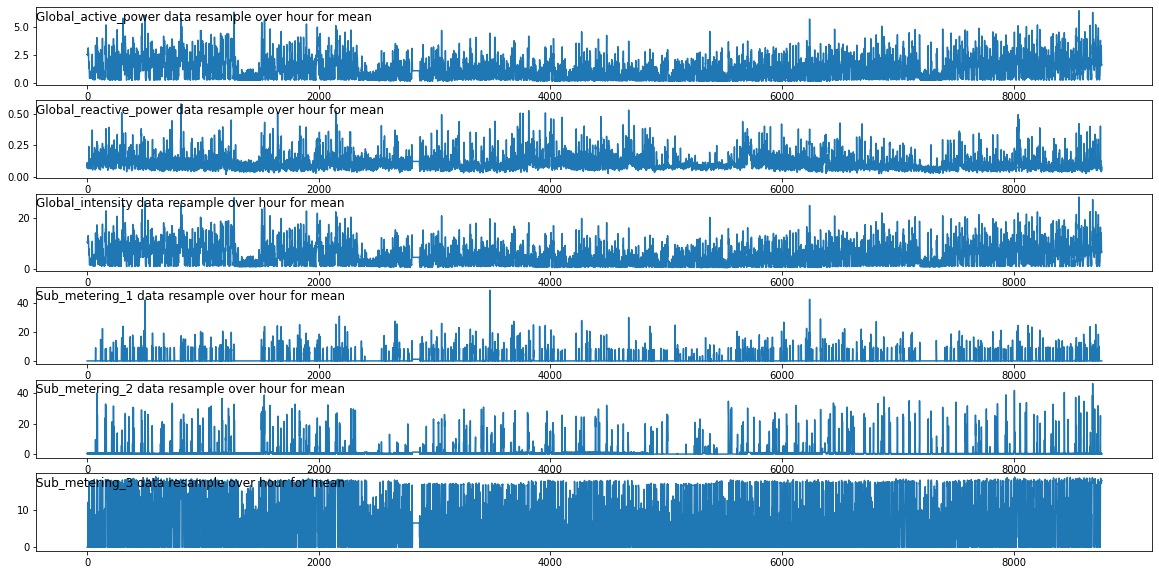

In [ ]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

### resampling to reduce

In [ ]:
df_resample = df.resample('h').mean() 
df_resample.shape

(8760, 7)

### Series to be 

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

### Splitting the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
test.shape

(7759, 8)

### Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ModuleNotFoundError: No module named 'tensorflow'